HA Data Science Internship Assessment
------------------

In this notebook we are building a model to classify *SCAMMERS* in listings of HousingAnywhere platform. We used Random Forest Classifier as it is fast and handy, especially when the dataset is heavily unbalanced.

We built three models with incremental complexity, and at the end we prunned the last one to avoid overfitting.

Let's jump in.

In [1]:
# Importing libraries

from datetime import datetime
start=datetime.now()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
# Importing dataset

train=pd.read_csv('HA_Data_Science_train.csv')

train.head(3)

,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL
0,1,Göteborg,725.00,False,NaN,se,se,0,80,False,1,Mobile Safari,iOS,0,bosqlqg@aol.com
1,1,Göteborg,469.35,False,NaN,se,se,1,70,False,1,Chrome,Android,0,fylm235670@gmail.com
2,1,Elche,200.00,False,NaN,es,es,0,25,False,0,Chrome,Android,0,mhzasjonfobc@gmail.com


In [3]:
AVG=np.round(train['IS_SCAMMER'].mean(),3)
AVG

0.058

As you see, the data is heavily unbalaced. Less than 6% of the listings are *SCAM*. So, to pick a metric as a criterion, *Accuracy* is not a good option since all-zero vector is 94% *accurate*!

Since having scams in the website is highly annoying, I believe that it is better to misclassify a normal (but low quality) entity as a scam rather than vice versa. So *Recall* is a better option, but since *f1-score* is the harmonic mean of *Recall* and *Precision* and here *Recall* is much less than *Precision*, the behavior of *f1* heavily depends on *Recall*. So, picking *f1* as our criterion seems like a wise choice.

In [4]:
criterion='f1'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16762 entries, 0 to 16761
Data columns (total 15 columns):
LISTING_KIND                     16762 non-null int64
LISTING_CITY                     16762 non-null object
LISTING_PRICE                    16762 non-null float64
IS_ARCHIVED                      16762 non-null bool
ARCHIVE_REASON                   1329 non-null object
LOGIN_COUNTRY_CODE               16733 non-null object
LISTING_COUNTRY_CODE             16762 non-null object
LISTING_REGISTRATION_POSSIBLE    16762 non-null int64
ADVERTISER_COMPLETENESS_SCORE    16762 non-null int64
MANAGED_ACCOUNT                  16762 non-null bool
HAS_PROFILE_PIC                  16762 non-null int64
BROWSER                          15877 non-null object
OS                               15877 non-null object
IS_SCAMMER                       16762 non-null int64
ANONYMISED_EMAIL                 16762 non-null object
dtypes: bool(2), float64(1), int64(5), object(7)
memory usage: 1.7+ MB


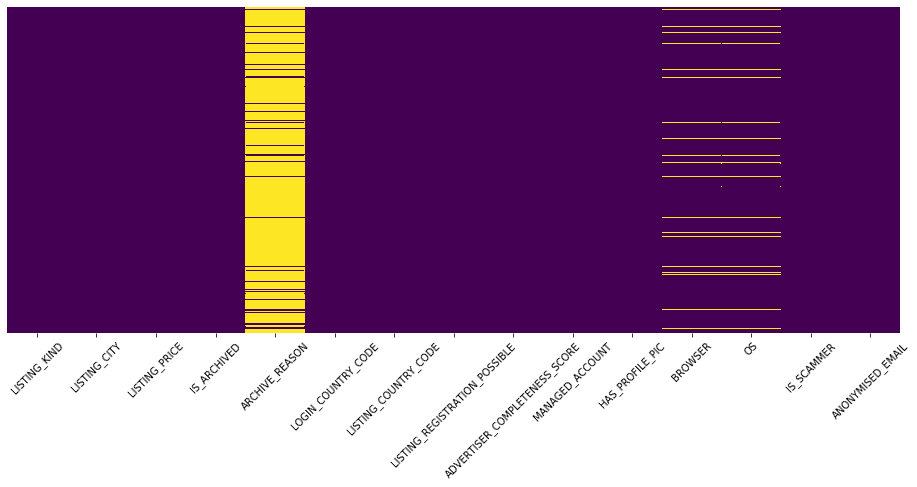

In [5]:
# Looking at column types and missing data

train.info(null_counts=True)
plt.figure(figsize=(16,6))
sns.heatmap(train.isnull(),cbar=False,cmap='viridis')
plt.xticks(rotation=45)
_=plt.yticks([])

---------------------

## Noob Model

Let's start with a noob model to get know data and also implement reporting function without any concern. So, we just use numberical columns and train a Random Forest Classifier. There was no null values in these columns, but to avoid any problem in the future, we impute these null values with rounded mean of each column.

In [6]:
noob_cols=['LISTING_KIND', 'LISTING_PRICE', 'LISTING_REGISTRATION_POSSIBLE', 'ADVERTISER_COMPLETENESS_SCORE',
         'MANAGED_ACCOUNT', 'HAS_PROFILE_PIC']

In [7]:
def noob_pre(df):
    for c in noob_cols:
        df[c]=df[c].fillna(np.round(np.mean(df[c])))
    return df
        
train=noob_pre(train)

In [8]:
X=train[noob_cols]
y=train['IS_SCAMMER']
split_ratio=0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

In [9]:
RFC0=RandomForestClassifier(100)
RFC0.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

As we use the same reporting for every model, we define a function to print *confusion matrix*, *classification report*, and also our criterion in a 3 fold cross validation.

It is also nice to see the ranking of features based on their importance.

In [10]:
def report_gen(RFC,Xt,yt):
    result=RFC.predict(Xt)
    print(confusion_matrix(yt,result))
    print('__________________________________')
    print(classification_report(yt,result))
    print('__________________________________')
    print('{} in 3 fold cross validation = '.format(criterion),  np.round(cross_val_score(RFC,Xt,yt,cv=3,scoring=criterion),2))
    order=np.argsort(RFC.feature_importances_)[::-1]
    plt.figure(figsize=(10,5))
    plt.title('Feature Importance')
    sns.barplot(y=Xt.columns[order],x=RFC.feature_importances_[order],palette="Blues_d",ci=None)

[[4631  101]
 [ 189  108]]
__________________________________
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4732
           1       0.52      0.36      0.43       297

    accuracy                           0.94      5029
   macro avg       0.74      0.67      0.70      5029
weighted avg       0.93      0.94      0.94      5029

__________________________________
f1 in 3 fold cross validation =  [0.41 0.36 0.4 ]


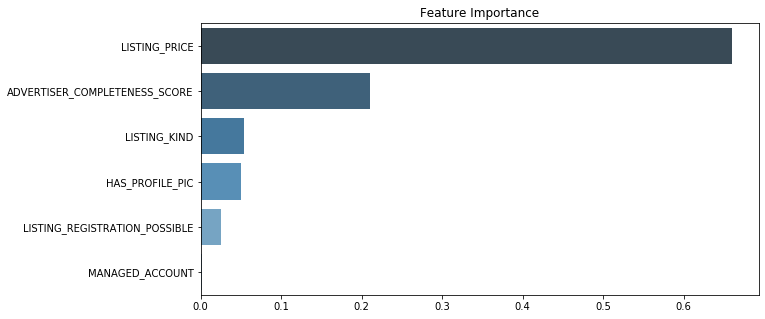

In [11]:
report_gen(RFC0,X_test,y_test)

As you see *LISTING_PRICE* followed by *COMPLETENESS_SCORE* is the most important feature among noob columns. So, let's go a bit further and try to use categorical features. As a very first idea, length of email address can be a criterion to distinguish scammers. The content of the email address is also informative, but since it is encoded here it is a bit tricky to use it. I have tried to realize the most common charcters within each classes and I found some results like that {'.','f','i'} are more likely to appear in a scamming post while {'1','2','5'} are more common in normal posts. But for the sake of simplicity I omit these complexities.

Also note that besides the magnitute of *LISTING_PRICE*, the fractional part of it may contains information. So, I have also included that one.

## Basic Model

In [12]:
def basic_pre(df):
    df['CODE_NULL']=df['LOGIN_COUNTRY_CODE'].isnull()
    df['SAME_CODE']=(df['LOGIN_COUNTRY_CODE']==df['LISTING_COUNTRY_CODE'])
    df['OS_NULL']=df['OS'].isnull()
    df['EMAIL_LEN']=df['ANONYMISED_EMAIL'].apply(lambda x:len(x.split('@')[0]))
    df['DOMAIN_LEN']=df['ANONYMISED_EMAIL'].apply(lambda x:len(x.split('@')[1]))
    df['FRACTIONAL']=df['LISTING_PRICE'].apply(lambda x:(x-np.floor(x)))
    return df
    
train=basic_pre(train)

In [13]:
basic_cols=['LISTING_KIND', 'LISTING_PRICE', 'LISTING_REGISTRATION_POSSIBLE', 'ADVERTISER_COMPLETENESS_SCORE',
         'MANAGED_ACCOUNT', 'HAS_PROFILE_PIC','SAME_CODE', 'OS_NULL', 'CODE_NULL', 'EMAIL_LEN',
         'DOMAIN_LEN', 'FRACTIONAL']

X=train[basic_cols]
y=train['IS_SCAMMER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

In [14]:
RFC1=RandomForestClassifier(100)
RFC1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[4723   40]
 [ 136  130]]
__________________________________
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4763
           1       0.76      0.49      0.60       266

    accuracy                           0.97      5029
   macro avg       0.87      0.74      0.79      5029
weighted avg       0.96      0.97      0.96      5029

__________________________________
f1 in 3 fold cross validation =  [0.54 0.44 0.53]


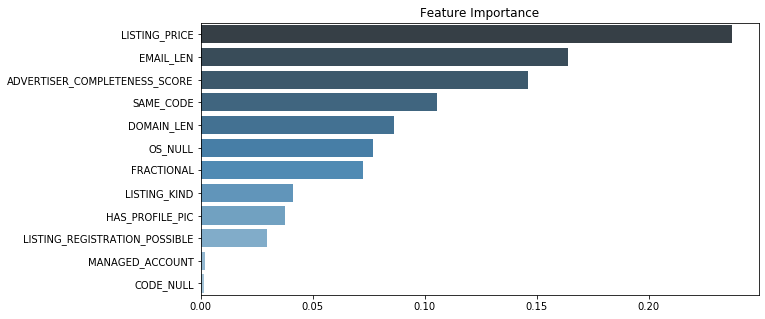

In [15]:
report_gen(RFC1,X_test,y_test)

As you see, we had a significat improvement is our criterion. Before we continue to the next level, let's also visualize the difference between the distribution of some features within two classes.

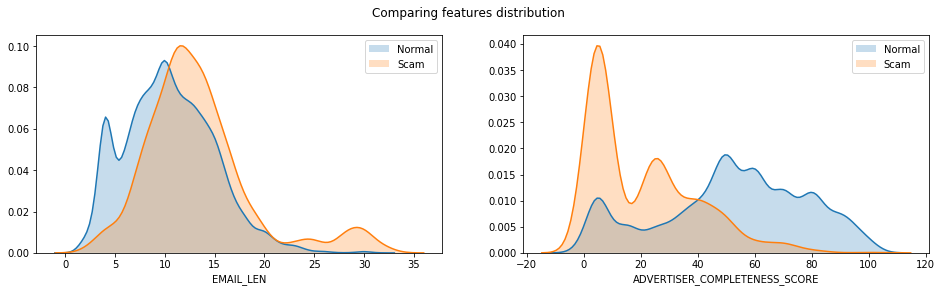

In [16]:
plt.figure(figsize=(16,4))
plt.suptitle('Comparing features distribution')
plt.subplot(1,2,1)
sns.distplot(X['EMAIL_LEN'][y==0],bins=range(50),hist=False,kde_kws={'shade':True})
sns.distplot(X['EMAIL_LEN'][y==1],bins=range(50),hist=False,kde_kws={'shade':True})
plt.legend(['Normal','Scam'])
plt.subplot(1,2,2)
sns.distplot(X['ADVERTISER_COMPLETENESS_SCORE'][y==0],bins=range(50),hist=False,kde_kws={'shade':True})
sns.distplot(X['ADVERTISER_COMPLETENESS_SCORE'][y==1],bins=range(50),hist=False,kde_kws={'shade':True})
_=plt.legend(['Normal','Scam'])

Nice!

Funny enough, *SCAMMERS* use longer email addresses! But for sure, their profile are emptier!

## Intermediate Model

So, let's be a bit more advance. As our categorical features are diverse, one hot encoding does not seem like a good idea. So, I define some probability of scamming for each category which is simply the number of scammers over the total number within each value. Also to avoid *the curse of small numbers* (and also null values), I just define this probability for the values that has been apeared more than a threshold, say 5 times. For the rest of the table I just use prior probability which is AVG as we defined.


In [17]:
CAT_FEAT=['OS','BROWSER','LISTING_COUNTRY_CODE','LOGIN_COUNTRY_CODE','LISTING_CITY']
TOTALS={}
PROBS={}
for c in CAT_FEAT:
    st=train.groupby(c)['IS_SCAMMER'].agg([sum,len])
    s=st['sum']
    t=st['len']
    TOTALS.update({c:t.to_dict()})
    PROBS.update({c:(s/t).to_dict()})
    

    
def CAT_IMPUTE(c,r,thresh=5):
    try:
        if TOTALS[c][r]>=thresh:
            return np.round(PROBS[c][r],3)
        else:
            return AVG
    except:
        return AVG

Also, deviation from the average price within each city can be informative. I use logarithm to smooth down the extreme values.

In [18]:
CITY_MEAN=train.groupby('LISTING_CITY')['LISTING_PRICE'].mean()
    

def MEAN_PRICE_DEV(r,thresh=5):
    try:
        if TOTALS['LISTING_CITY'][r]>=thresh:
            return np.abs(np.round(np.log(CITY_MEAN[r]),3))
        else:
            return 0
    except:
        return 0

In [19]:
def intermediate_pre(df):
    
    for c in CAT_FEAT:
        df['{}_IMP'.format(c)]=df[c].apply(lambda x:CAT_IMPUTE(c,x))
    df['CITY_MEAN_DEV']=df['LISTING_CITY'].apply(MEAN_PRICE_DEV)
    return df
    
    
train=intermediate_pre(train)

In [20]:
intermediate_cols=['LISTING_KIND', 'LISTING_PRICE','LISTING_REGISTRATION_POSSIBLE', 'ADVERTISER_COMPLETENESS_SCORE',
       'MANAGED_ACCOUNT', 'HAS_PROFILE_PIC', 'SAME_CODE', 'OS_NULL', 'CODE_NULL', 'EMAIL_LEN',
         'DOMAIN_LEN', 'FRACTIONAL','OS_IMP', 'BROWSER_IMP', 'LISTING_COUNTRY_CODE_IMP',
       'LOGIN_COUNTRY_CODE_IMP', 'LISTING_CITY_IMP', 'CITY_MEAN_DEV']

X=train[intermediate_cols]
y=train['IS_SCAMMER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio)

In [21]:
RFC2=RandomForestClassifier(100)
RFC2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[4720   15]
 [ 112  182]]
__________________________________
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4735
           1       0.92      0.62      0.74       294

    accuracy                           0.97      5029
   macro avg       0.95      0.81      0.86      5029
weighted avg       0.97      0.97      0.97      5029

__________________________________
f1 in 3 fold cross validation =  [0.76 0.58 0.67]


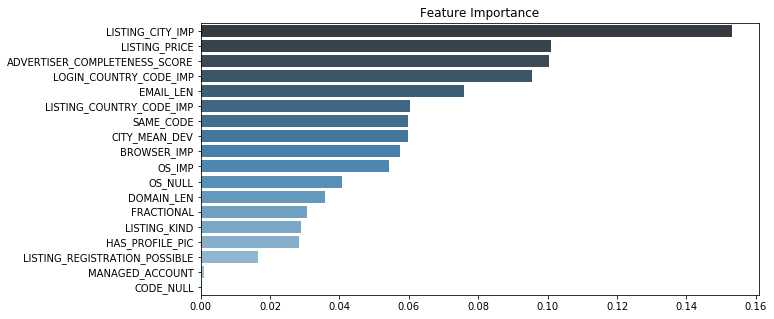

In [22]:
report_gen(RFC2,X_test,y_test)

## Pruning

As we were lavish in adding columns, there is the chance of overfitting. We may randomly drop some columns and find the best combination. Of course, we are overfitting on this specific test set, but we may also trust Occam's razor!

The following code, randomly drop 4 columns and keep the best combination due to our criterion, f1-score. You may uncomment it to override the model, it will takes about 10 minutes.

In [23]:
Model=RFC2
FINAL_COLS=intermediate_cols

In [24]:
#from tqdm import tqdm
#import random

# n_iteration=1000
# COLS=[]
# Scores=[]
# for iteration in tqdm(range(n_iteration)):
#     mycol=random.sample(intermediate_cols, 14)
#     Xt=X_test[mycol]
#     RFC3=RandomForestClassifier(100)
#     RFC3.fit(Xt,y_test)
#     result=RFC3.predict(Xt)
#     COLS.append(mycol)
#     Scores.append(np.mean(cross_val_score(RFC3,Xt,y_test,cv=3,scoring=criterion)))
    
# FINAL_COLS=COLS[np.argmax(Scores)]
    
# print('DELETED FEATURES ARE :\n\n',list(set(intermediate_cols)-set(FINAL_COLS)))
# print('____________________________________')

# Model=RandomForestClassifier(100)
# Model.fit(X_train[FINAL_COLS],y_train)
# report_gen(Model,X_test[FINAL_COLS],y_test)

If you have uncommented the lines above, you might even recieve a slightly worse result, at least in the sense of *Precision*. 
But even in this case, you have a simpler algorithm with almost similar power.

## Submission

That's it. Let's import the test set and apply our model after preprocessing.

In [25]:
test=pd.read_csv('HA_Data_Science_test.csv')

In [26]:
test=noob_pre(test)
test=basic_pre(test)
test=intermediate_pre(test)

In [27]:
result=Model.predict(test[FINAL_COLS])

In [28]:
test['IS_SCAMMER']=result
test.to_csv('HA_Data_Science_test_labeled.csv',index=False)

In [29]:
diff=datetime.now()-start
print('Mission completed in {} seconds!\n\n{}% of the test data are categorized as SCAM.'.format(diff.seconds,np.round(100*sum(result)/len(result),2)))

Mission completed in 26 seconds!

3.75% of the test data are categorized as SCAM.
